In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/TUTORIAS/tutorias_facultad_2015_2024.csv')

In [ ]:
df['anio'].value_counts().sort_index()

,count
anio,
2015,30
2016,30
2017,30
2018,30
2019,30
2020,30
2021,30
2022,30
2023,30


In [ ]:
df.head(10)

,facultad_id,nombre_facultad,anio,matricula_h,matricula_m,tot_matricula,h_primer,m_primer,tot_primer,h_tercer,m_tercer,tot_tercer,extranjeros,habla_indigena,discapacitados,pri_terminacion,h_egresados,m_egresados,t_egresados,pri_titulacion,h_titulados,m_titulados,t_titulados,intervenciones_personalizadas,intervenciones_pequeno_grupo,intervenciones_grupales,intervenciones_alumnos_en_riesgo,total_intervenciones,total_de_tutores,total_de_tutorados_individual,grupos_en_tutoria,total_de_tutorados_grupal,total_de_estudiantes_atendidos,total_de_estudiantes_asignados_en_tutoria,alumnos_en_riesgo,alumnos_alto,alumnos_medio,alumnos_bajo,h_tiempo_completo,m_tiempo_completo,tot_tiempo_completo,h_x_horas,m_x_horas,tot_x_horas
0,1,ESCUELA DE COMERCIO EXTERIOR,2015,265,295,560,104,55,159,76,66,142,6,1,0,161,47,82,129,163,39,88,127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,0,6,14,11,25
1,2,ESCUELA DE GASTRONOMÍA Y TURISMO,2015,95,160,255,42,29,71,23,32,55,11,0,0,40,8,20,28,41,22,28,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,4,5,5,11,16
2,3,FACULTAD DE CIENCIAS MARINAS,2015,128,106,234,49,29,78,26,31,57,0,0,2,84,28,15,43,82,16,11,27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,7,23,8,8,16
3,4,FACULTAD DE CONTABILIDAD Y ADMÓN. MANZANILLO,2015,263,316,579,83,61,144,60,56,116,0,3,0,199,57,86,143,134,42,58,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,1,5,23,14,37
4,5,FACULTAD DE INGENIERÍA ELECTROMECÁNICA,2015,349,41,390,97,7,104,74,8,82,1,0,2,218,104,7,111,82,31,1,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,2,15,26,4,30
5,6,FACULTAD DE CIENCIAS BIOLÓGICAS Y AGROPECUARIAS,2015,329,99,428,96,29,125,57,26,83,1,0,1,89,41,13,54,70,19,8,27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,1,10,19,12,31
6,7,FACULTAD DE CONTABILIDAD Y ADMÓN. TECOMÁN,2015,277,245,522,103,42,145,60,55,115,0,0,4,152,50,63,113,137,45,21,66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,1,13,23,6,29
7,8,FACULTAD DE MEDICINA VETERINARIA Y ZOOTECNIA,2015,129,97,226,40,27,67,23,29,52,2,0,2,43,9,9,18,57,9,9,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11,1,12,13,7,20
8,9,ESCUELA DE MERCADOTECNIA,2015,202,218,420,74,60,134,40,62,102,6,0,0,132,37,43,80,118,25,36,61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,4,10,21,29,50
9,10,FACULTAD DE CIENCIAS,2015,79,44,123,26,21,47,11,11,22,1,0,1,56,10,6,16,43,4,1,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,3,18,6,4,10


In [ ]:
# ---------------------------------------------------
# 1) Columnas que quieres rellenar SOLO para 2015
# ---------------------------------------------------
cols_faltan_2015 = [
    'intervenciones_personalizadas',
    'intervenciones_pequeno_grupo',
    'intervenciones_grupales',
    'intervenciones_alumnos_en_riesgo',
    'total_intervenciones',
    'total_de_tutores',
    'total_de_tutorados_individual',
    'grupos_en_tutoria',
    'total_de_tutorados_grupal',
    'total_de_estudiantes_atendidos',
    'total_de_estudiantes_asignados_en_tutoria',
    'alumnos_en_riesgo',
    'alumnos_alto',
    'alumnos_medio',
    'alumnos_bajo'
]
# Asegúrate que anio es int
df['anio'] = df['anio'].astype(int)

# Idea matemática
Para cada facultad y cada variable de $cols\_faltan\_2015$:

1. Tomamos sus valores históricos 2016-2023:

$$ x_t= año, y_t = valor de la variable $$

2. Ajustamos una recta por mínimos cuadrados:
$$y=\beta_0 + \beta_1 x$$

3. Extrapolamos a 2015:
$$\hat{y}_{2015}=\beta_0+\beta_1 \cdot 2015$$

4. Redondeamos a entero y truncamos a mínimo 0 (porque son conteos).

Si una facultad solo tiene 1 dato (un año disponible), en vez de ajustar recta usamos directamente ese valor como aproximación para 2015.

In [ ]:


def rellenar_2015_por_extrapolacion(df):
    df = df.copy()

    # Recorremos cada variable a completar
    for col in cols_faltan_2015:
        # Por facultad se ajusta una recta sobre 2016–2023
        for fac_id, g in df.groupby('facultad_id'):
            # Fila(s) de 2015 de esa facultad con NaN en la columna
            mask_2015 = (
                (df['facultad_id'] == fac_id) &
                (df['anio'] == 2015) &
                (df[col].isna())
            )
            if not mask_2015.any():
                continue

            # Datos históricos 2016–2023 para esa facultad y variable
            hist = g[
                (g['anio'] >= 2016) &
                (g['anio'] <= 2023) &
                (g[col].notna())
            ]

            if hist.empty:
                # No tenemos nada para ajustar -> se deja NaN
                continue

            x = hist['anio'].values.astype(float)
            y = hist[col].values.astype(float)

            if len(hist) == 1:
                # Solo un punto: usamos ese valor como aproximación
                y_2015 = y[0]
            else:
                # Ajuste lineal y = a*x + b
                a, b = np.polyfit(x, y, 1)
                y_2015 = a * 2015 + b

            # Redondeamos a entero y no permitimos negativos
            y_2015 = max(0, int(round(y_2015)))

            # Asignamos el valor estimado a 2015 para esa facultad
            df.loc[mask_2015, col] = y_2015

    return df

# Uso:
df_extrap = rellenar_2015_por_extrapolacion(df)


# Tasas históricas de deserción (2016-2023)
Para cada facultad:
$$tasa\_desercion = 1 - \frac{tercer\_semestre}{primer\_semestre}$$

* Usaeremos el promedio suavizado para evitar valores extremos.

Luego usamos esta tasa para simular 2024:
$$tercer\_sem\_2024= primer\_ingreso\_2024 \cdot (1-tasa\_desercion\_hist)$$

Con redondeo a enteros y sin negativos.

#Consistencia con matriz matrícula
Necesitamos:
$$matricula\_total\_2024 \geq primer\_2024 + tercer\_2024$$

Para 2024 no se tienen datos de matrícula, así que también la estimamos por tendencia (2016-2023).

Luego verificamos:
$$matricula\_est = max(matricula\_est, primer+tercer)$$

#Egresados y titulados
Para egresados:
$$tasa\_egresos = \frac{egresados}{primer\_ingreso}$$
Para titulados:
$$tasa\_tit = \frac{titulados}{egresados}$$
Luego:
$$egresados\_2024 = primer\_2024 \cdot tasa\_egreso$$
$$titulados\_2024 = egresados\_2024 \cdot tasa\_tit$$

In [ ]:

# -----------------------------------------------------
# 1) Función: calcular tasa histórica suavizada
# -----------------------------------------------------
def tasa_media(series_a, series_b):
    """ Devuelve promedio histórico de a/b eliminando NaN y divisiones inválidas """
    tasas = series_b / series_a.replace(0, np.nan)
    tasas = tasas.dropna()
    if tasas.empty:
        return np.nan
    return tasas.mean()

# -----------------------------------------------------
# 2) Generar datos 2024 por facultad
# -----------------------------------------------------
def generar_2024(df):

    df = df.copy()
    facultades = df['facultad_id'].unique()

    registros_2024 = []

    for fac in facultades:

        g = df[df['facultad_id'] == fac]

        # --- series históricas 2016–2023 ---
        hist = g[(g['anio'] >= 2016) & (g['anio'] <= 2023)]

        # =======================================================
        # 1) Extrapolar matrícula para 2024
        # =======================================================
        if len(hist) >= 2:
            a, b = np.polyfit(hist['anio'], hist['matricula_total'], 1)
            matricula_est = a * 2024 + b
        else:
            matricula_est = hist['matricula_total'].iloc[-1]

        matricula_est = max(0, int(round(matricula_est)))

        # =======================================================
        # 2) Extrapolar primer ingreso 2024
        # =======================================================
        if len(hist) >= 2:
            a, b = np.polyfit(hist['anio'], hist['tot_primer'], 1)
            tot_primer_24 = a * 2024 + b
        else:
            tot_primer_24 = hist['tot_primer'].iloc[-1]

        tot_primer_24 = max(1, int(round(tot_primer_24)))   # mínimo 1

        # Proporción H/M histórica
        p_h = hist['h_primer'].sum() / hist['tot_primer'].sum()
        p_m = 1 - p_h

        h_primer_24 = int(round(tot_primer_24 * p_h))
        m_primer_24 = tot_primer_24 - h_primer_24

        # =======================================================
        # 3) Tasa de deserción → tercer semestre 2024
        # =======================================================
        tasa_deserc = tasa_media(hist['tot_primer'], hist['tot_tercer'])
        if np.isnan(tasa_deserc):
            tasa_deserc = 0.15   # fallback

        tot_tercer_24 = int(round(tot_primer_24 * tasa_deserc))
        h_tercer_24 = int(round(h_primer_24 * tasa_deserc))
        m_tercer_24 = tot_tercer_24 - h_tercer_24

        # Consistencia con matrícula
        matricula_est = max(matricula_est, tot_primer_24 + tot_tercer_24)

        # =======================================================
        # 4) Egresados y titulados
        # =======================================================
        tasa_egreso = tasa_media(hist['tot_primer'], hist['t_egresados'])
        tasa_tit = tasa_media(hist['t_egresados'], hist['t_titulados'])

        if np.isnan(tasa_egreso): tasa_egreso = 0.40
        if np.isnan(tasa_tit):   tasa_tit = 0.80

        t_egresados_24 = int(round(tot_primer_24 * tasa_egreso))
        t_titulados_24 = int(round(t_egresados_24 * tasa_tit))

        # =======================================================
        # 5) Otras variables → extrapolación lineal simple
        # =======================================================
        def extrapolar(col):
            if col not in hist:
                return None
            if hist[col].count() < 2:
                return int(hist[col].dropna().iloc[-1]) if hist[col].count() == 1 else None
            a, b = np.polyfit(hist['anio'], hist[col], 1)
            val = a * 2024 + b
            return max(0, int(round(val)))

        registro = {
            'facultad_id': fac,
            'anio': 2024,
            'matricula_total': matricula_est,
            'h_primer': h_primer_24,
            'm_primer': m_primer_24,
            'tot_primer': tot_primer_24,
            'h_tercer': h_tercer_24,
            'm_tercer': m_tercer_24,
            'tot_tercer': tot_tercer_24,
            't_egresados': t_egresados_24,
            't_titulados': t_titulados_24,
        }

        registros_2024.append(registro)

    df2024 = pd.DataFrame(registros_2024)
    return df2024


In [ ]:
df_extrap['anio'] = df_extrap['anio'].astype(int)

In [ ]:

def safe_ratio_mean(num, den):
    """
    Promedio de num/den (por ejemplo t_egresados / pri_terminacion),
    ignorando ceros y NaN.
    """
    den_safe = den.replace(0, np.nan)
    ratios = num / den_safe
    ratios = ratios.replace([np.inf, -np.inf], np.nan).dropna()
    if ratios.empty:
        return np.nan
    return ratios.mean()

def linear_extrap(hist, col, year_target):
    """
    Extrapolación lineal simple para una columna numérica
    usando hist['anio'] como x y hist[col] como y.
    """
    if col not in hist.columns:
        return np.nan
    h = hist[['anio', col]].dropna()
    if h.empty:
        return np.nan
    if len(h) == 1:
        return float(h[col].iloc[0])
    a, b = np.polyfit(h['anio'], h[col], 1)
    return a * year_target + b


In [ ]:
def generar_2024_y_agregar(df_extrap):

    df = df_extrap.copy()
    df['anio'] = df['anio'].astype(int)

    facultades = df['facultad_id'].unique()
    registros_2024 = []

    for fac in facultades:

        g_all   = df[(df['facultad_id'] == fac) & (df['anio'] <= 2023)]
        g_2016_23 = g_all[(g_all['anio'] >= 2016) & (g_all['anio'] <= 2023)]

        if g_all.empty or g_2016_23.empty:
            # Si no hay historia, no inventamos nada
            continue

        nombre_fac = g_all['nombre_facultad'].iloc[0]

        # ================================
        # 1) Primer y tercer semestre 2024
        # ================================
        # tot_primer: extrapolación lineal con historia 2015–2023
        val_tot_primer = linear_extrap(g_all, 'tot_primer', 2024)
        if np.isnan(val_tot_primer):
            # fallback tonto si algo anda mal
            val_tot_primer = g_all['tot_primer'].dropna().iloc[-1]

        tot_primer_24 = max(1, int(round(val_tot_primer)))

        # proporción H/M en primer ingreso (historial)
        tot_primer_hist_sum = g_all['tot_primer'].sum()
        if tot_primer_hist_sum > 0:
            p_h_primer = g_all['h_primer'].sum() / tot_primer_hist_sum
        else:
            p_h_primer = 0.5

        h_primer_24 = int(round(tot_primer_24 * p_h_primer))
        m_primer_24 = tot_primer_24 - h_primer_24

        # ===== Tasa de retención 3er semestre (2016–2023) =====
        tasa_retencion = safe_ratio_mean(
            g_2016_23['tot_tercer'],
            g_2016_23['tot_primer']
        )
        if np.isnan(tasa_retencion):
            tasa_retencion = 0.8  # fallback razonable

        # tot_tercer = tot_primer * tasa_retención
        tot_tercer_24 = int(round(tot_primer_24 * tasa_retencion))

        # proporción H/M en tercer semestre histórica
        tot_tercer_hist_sum = g_2016_23['tot_tercer'].sum()
        if tot_tercer_hist_sum > 0:
            p_h_tercer = g_2016_23['h_tercer'].sum() / tot_tercer_hist_sum
        else:
            p_h_tercer = p_h_primer  # si no hay info, usamos la misma

        h_tercer_24 = int(round(tot_tercer_24 * p_h_tercer))
        m_tercer_24 = tot_tercer_24 - h_tercer_24

        # Aseguramos totales como suma de sexos (por si hubo redondeo)
        tot_tercer_24 = h_tercer_24 + m_tercer_24
        tot_primer_24 = h_primer_24 + m_primer_24

        # ================================
        # 2) Matrícula 2024 (con restricciones)
        # ================================
        val_tot_matr = linear_extrap(g_all, 'tot_matricula', 2024)
        if np.isnan(val_tot_matr):
            val_tot_matr = g_all['tot_matricula'].dropna().iloc[-1]
        tot_matricula_24 = int(round(max(0, val_tot_matr)))

        # proporción H/M en matrícula
        matr_hist_sum = g_all['tot_matricula'].sum()
        if matr_hist_sum > 0:
            p_h_matr = g_all['matricula_h'].sum() / matr_hist_sum
        else:
            p_h_matr = 0.5

        matricula_h_24 = int(round(tot_matricula_24 * p_h_matr))
        matricula_m_24 = tot_matricula_24 - matricula_h_24

        # Restricción: matrícula_h >= h_primer + h_tercer
        need_h = h_primer_24 + h_tercer_24
        need_m = m_primer_24 + m_tercer_24
        need_tot = tot_primer_24 + tot_tercer_24

        if matricula_h_24 < need_h:
            matricula_h_24 = need_h
        if matricula_m_24 < need_m:
            matricula_m_24 = need_m

        tot_matricula_24 = max(
            tot_matricula_24,
            matricula_h_24 + matricula_m_24,
            need_tot
        )

        # ================================
        # 3) Egresados y titulados 2024
        # ================================
        # pri_terminacion≈cohorte de primer ingreso
        pri_terminacion_24 = tot_primer_24

        tasa_egreso = safe_ratio_mean(
            g_2016_23['t_egresados'],
            g_2016_23['pri_terminacion']
        )
        if np.isnan(tasa_egreso):
            tasa_egreso = 0.4

        t_egresados_24 = int(round(pri_terminacion_24 * tasa_egreso))

        # proporción H/M egreso
        t_eg_hist = g_2016_23['t_egresados'].sum()
        if t_eg_hist > 0:
            p_h_eg = g_2016_23['h_egresados'].sum() / t_eg_hist
        else:
            p_h_eg = p_h_primer

        h_egresados_24 = int(round(t_egresados_24 * p_h_eg))
        m_egresados_24 = t_egresados_24 - h_egresados_24
        t_egresados_24 = h_egresados_24 + m_egresados_24

        # Titulación
        pri_titulacion_24 = pri_terminacion_24

        tasa_tit = safe_ratio_mean(
            g_2016_23['t_titulados'],
            g_2016_23['pri_titulacion']
        )
        if np.isnan(tasa_tit):
            tasa_tit = 0.8

        t_titulados_24 = int(round(pri_titulacion_24 * tasa_tit))

        t_tit_hist = g_2016_23['t_titulados'].sum()
        if t_tit_hist > 0:
            p_h_tit = g_2016_23['h_titulados'].sum() / t_tit_hist
        else:
            p_h_tit = p_h_eg

        h_titulados_24 = int(round(t_titulados_24 * p_h_tit))
        m_titulados_24 = t_titulados_24 - h_titulados_24
        t_titulados_24 = h_titulados_24 + m_titulados_24

        # ================================
        # 4) Otras columnas numéricas → extrapolación lineal
        # ================================
        # Columnas que vamos a calcular "a mano" (las demás: extrapolación)
        manual_cols = {
            'facultad_id',
            'nombre_facultad',
            'anio',
            'matricula_h', 'matricula_m', 'tot_matricula',
            'h_primer', 'm_primer', 'tot_primer',
            'h_tercer', 'm_tercer', 'tot_tercer',
            'pri_terminacion', 'h_egresados', 'm_egresados', 't_egresados',
            'pri_titulacion', 'h_titulados', 'm_titulados', 't_titulados',
            'h_tiempo_completo', 'm_tiempo_completo', 'tot_tiempo_completo',
            'h_x_horas', 'm_x_horas', 'tot_x_horas'
        }

        # columnas numéricas candidatas a extrapolación
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        other_cols = [
            c for c in numeric_cols
            if c not in manual_cols and c not in ['anio', 'facultad_id']
        ]

        registro = {
            'facultad_id': fac,
            'nombre_facultad': nombre_fac,
            'anio': 2024,
            'matricula_h': matricula_h_24,
            'matricula_m': matricula_m_24,
            'tot_matricula': tot_matricula_24,
            'h_primer': h_primer_24,
            'm_primer': m_primer_24,
            'tot_primer': tot_primer_24,
            'h_tercer': h_tercer_24,
            'm_tercer': m_tercer_24,
            'tot_tercer': tot_tercer_24,
            'pri_terminacion': pri_terminacion_24,
            'h_egresados': h_egresados_24,
            'm_egresados': m_egresados_24,
            't_egresados': t_egresados_24,
            'pri_titulacion': pri_titulacion_24,
            'h_titulados': h_titulados_24,
            'm_titulados': m_titulados_24,
            't_titulados': t_titulados_24,
        }

        # Extrapolamos el resto de variables (extranjeros, intervenciones, riesgo, personal, etc.)
        for col in other_cols:
            val = linear_extrap(g_all, col, 2024)
            if np.isnan(val):
                registro[col] = np.nan
            else:
                registro[col] = max(0, int(round(val)))

        # Personal: totales de tiempo completo y por horas
        if 'h_tiempo_completo' in df.columns:
            val_h_tc = linear_extrap(g_all, 'h_tiempo_completo', 2024)
            val_m_tc = linear_extrap(g_all, 'm_tiempo_completo', 2024)
            h_tc_24 = 0 if np.isnan(val_h_tc) else max(0, int(round(val_h_tc)))
            m_tc_24 = 0 if np.isnan(val_m_tc) else max(0, int(round(val_m_tc)))
            registro['h_tiempo_completo'] = h_tc_24
            registro['m_tiempo_completo'] = m_tc_24
            registro['tot_tiempo_completo'] = h_tc_24 + m_tc_24

        if 'h_x_horas' in df.columns:
            val_h_x = linear_extrap(g_all, 'h_x_horas', 2024)
            val_m_x = linear_extrap(g_all, 'm_x_horas', 2024)
            h_x_24 = 0 if np.isnan(val_h_x) else max(0, int(round(val_h_x)))
            m_x_24 = 0 if np.isnan(val_m_x) else max(0, int(round(val_m_x)))
            registro['h_x_horas'] = h_x_24
            registro['m_x_horas'] = m_x_24
            registro['tot_x_horas'] = h_x_24 + m_x_24

        registros_2024.append(registro)

    df_2024 = pd.DataFrame(registros_2024)

    # Alineamos columnas al orden original
    df_2024 = df_2024.reindex(columns=df_extrap.columns)

    # Concatenamos
    df_final = pd.concat([df_extrap, df_2024], ignore_index=True)

    # Ordenado por facultad y año
    df_final = df_final.sort_values(['facultad_id', 'anio']).reset_index(drop=True)

    return df_final

# Uso:
df_extrap = generar_2024_y_agregar(df_extrap)


In [ ]:
df_extrap[df_extrap['anio'].isin([2023, 2024])]


,facultad_id,nombre_facultad,anio,matricula_h,matricula_m,tot_matricula,h_primer,m_primer,tot_primer,h_tercer,m_tercer,tot_tercer,extranjeros,habla_indigena,discapacitados,pri_terminacion,h_egresados,m_egresados,t_egresados,pri_titulacion,h_titulados,m_titulados,t_titulados,intervenciones_personalizadas,intervenciones_pequeno_grupo,intervenciones_grupales,intervenciones_alumnos_en_riesgo,total_intervenciones,total_de_tutores,total_de_tutorados_individual,grupos_en_tutoria,total_de_tutorados_grupal,total_de_estudiantes_atendidos,total_de_estudiantes_asignados_en_tutoria,alumnos_en_riesgo,alumnos_alto,alumnos_medio,alumnos_bajo,h_tiempo_completo,m_tiempo_completo,tot_tiempo_completo,h_x_horas,m_x_horas,tot_x_horas
8,1,ESCUELA DE COMERCIO EXTERIOR,2023,393,604,997,67,121,188,60,112,172,11,1,3,162,34,80,114,197,41,87,128,238.0,14.0,56.0,264.0,572.0,17.0,594.0,18.0,595.0,561.0,595.0,201.0,64.0,60.0,77.0,5,1,6,12,13,25
9,1,ESCUELA DE COMERCIO EXTERIOR,2024,294,475,769,71,102,173,54,97,151,9,1,2,173,52,85,137,173,45,75,120,242.0,12.0,54.0,284.0,611.0,18.0,618.0,18.0,595.0,643.0,597.0,222.0,72.0,72.0,78.0,5,0,5,7,8,15
18,2,ESCUELA DE GASTRONOMÍA Y TURISMO,2023,193,283,476,33,51,84,29,46,75,3,0,1,64,9,26,35,67,14,23,37,119.0,15.0,90.0,189.0,413.0,10.0,4.0,11.0,252.0,285.0,255.0,70.0,24.0,28.0,18.0,1,4,5,5,11,16
19,2,ESCUELA DE GASTRONOMÍA Y TURISMO,2024,120,230,350,32,50,82,23,45,68,2,0,1,82,16,39,55,82,15,34,49,126.0,13.0,79.0,206.0,437.0,9.0,0.0,13.0,319.0,332.0,317.0,86.0,37.0,26.0,23.0,1,4,5,6,12,18
28,3,FACULTAD DE CIENCIAS MARINAS,2023,124,212,336,28,26,54,18,17,35,0,1,1,88,18,15,33,65,4,7,11,26.0,92.0,34.0,143.0,295.0,18.0,80.0,10.0,132.0,217.0,212.0,131.0,64.0,35.0,32.0,7,1,8,11,12,23
29,3,FACULTAD DE CIENCIAS MARINAS,2024,120,142,262,33,34,67,18,23,41,1,0,0,67,15,15,30,67,8,7,15,0.0,92.0,30.0,154.0,271.0,19.0,91.0,8.0,101.0,209.0,202.0,196.0,106.0,44.0,46.0,4,0,4,15,12,27
38,4,FACULTAD DE CONTABILIDAD Y ADMÓN. MANZANILLO,2023,358,569,927,65,101,166,54,88,142,2,1,8,156,41,70,111,161,31,52,83,119.0,3.0,93.0,198.0,413.0,20.0,0.0,20.0,567.0,480.0,567.0,165.0,54.0,67.0,44.0,5,1,6,13,16,29
39,4,FACULTAD DE CONTABILIDAD Y ADMÓN. MANZANILLO,2024,293,421,714,77,98,175,57,87,144,2,0,4,175,49,74,123,175,39,64,103,221.0,14.0,116.0,343.0,706.0,19.0,0.0,18.0,543.0,499.0,542.0,247.0,86.0,93.0,68.0,7,1,8,13,15,28
48,5,FACULTAD DE INGENIERÍA ELECTROMECÁNICA,2023,85,495,580,112,30,142,87,21,108,5,1,6,140,53,6,59,120,36,6,42,339.0,24.0,19.0,323.0,705.0,19.0,0.0,20.0,495.0,460.0,495.0,315.0,133.0,100.0,82.0,9,2,11,17,5,22
49,5,FACULTAD DE INGENIERÍA ELECTROMECÁNICA,2024,382,123,505,127,20,147,87,15,102,3,2,5,147,74,11,85,147,67,9,76,180.0,26.0,25.0,213.0,449.0,20.0,0.0,19.0,404.0,405.0,459.0,388.0,170.0,114.0,104.0,8,2,10,15,6,21


In [ ]:
errores_matricula = df_extrap[
    df_extrap['tot_matricula'] < df_extrap['tot_primer'] + df_extrap['tot_tercer']
]

errores_matricula


,facultad_id,nombre_facultad,anio,matricula_h,matricula_m,tot_matricula,h_primer,m_primer,tot_primer,h_tercer,m_tercer,tot_tercer,extranjeros,habla_indigena,discapacitados,pri_terminacion,h_egresados,m_egresados,t_egresados,pri_titulacion,h_titulados,m_titulados,t_titulados,intervenciones_personalizadas,intervenciones_pequeno_grupo,intervenciones_grupales,intervenciones_alumnos_en_riesgo,total_intervenciones,total_de_tutores,total_de_tutorados_individual,grupos_en_tutoria,total_de_tutorados_grupal,total_de_estudiantes_atendidos,total_de_estudiantes_asignados_en_tutoria,alumnos_en_riesgo,alumnos_alto,alumnos_medio,alumnos_bajo,h_tiempo_completo,m_tiempo_completo,tot_tiempo_completo,h_x_horas,m_x_horas,tot_x_horas
251,26,ESCUELA DE FILOSOFÍA,2016,20,11,31,14,9,23,8,7,15,1,0,0,0,0,0,0,21,4,5,9,0.0,0.0,2.0,0.0,2.0,4.0,31.0,2.0,7.0,0.0,33.0,0.0,0.0,0.0,0.0,2,1,3,6,3,9
296,30,FACULTAD DE PEDAGOGÍA,2021,52,286,338,14,86,100,186,73,259,6,0,2,95,4,69,73,98,10,44,54,36.0,41.0,10.0,54.0,141.0,24.0,90.0,12.0,338.0,167.0,338.0,63.0,17.0,23.0,23.0,5,4,9,12,13,25


In [ ]:
errores_retencion = df_extrap[
    df_extrap['anio'] == 2024
][
    df_extrap['tot_tercer'] >= df_extrap['tot_primer']
]

errores_retencion


/tmp/ipython-input-13726034.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  errores_retencion = df_extrap[


,facultad_id,nombre_facultad,anio,matricula_h,matricula_m,tot_matricula,h_primer,m_primer,tot_primer,h_tercer,m_tercer,tot_tercer,extranjeros,habla_indigena,discapacitados,pri_terminacion,h_egresados,m_egresados,t_egresados,pri_titulacion,h_titulados,m_titulados,t_titulados,intervenciones_personalizadas,intervenciones_pequeno_grupo,intervenciones_grupales,intervenciones_alumnos_en_riesgo,total_intervenciones,total_de_tutores,total_de_tutorados_individual,grupos_en_tutoria,total_de_tutorados_grupal,total_de_estudiantes_atendidos,total_de_estudiantes_asignados_en_tutoria,alumnos_en_riesgo,alumnos_alto,alumnos_medio,alumnos_bajo,h_tiempo_completo,m_tiempo_completo,tot_tiempo_completo,h_x_horas,m_x_horas,tot_x_horas,prop_h_primer,tasa_desercion
299,30,FACULTAD DE PEDAGOGÍA,2024,90,323,413,18,70,88,32,61,93,3,2,2,88,12,59,71,88,10,45,55,37.0,35.0,25.0,56.0,155.0,25.0,93.0,12.0,299.0,286.0,305.0,70.0,18.0,17.0,34.0,5,4,9,9,12,21,0.204545,-0.056818


In [ ]:

fac_id = 30

# Aseguramos tipo int por si acaso
df_extrap['anio'] = df_extrap['anio'].astype(int)

# Historial 2016–2023 de esa facultad
hist_30 = df_extrap[
    (df_extrap['facultad_id'] == fac_id) &
    (df_extrap['anio'].between(2016, 2023)) &
    (df_extrap['tot_primer'] > 0)
].copy()

# Nos quedamos solo con años donde el tercer semestre no supera al primero
hist_30 = hist_30[hist_30['tot_tercer'] <= hist_30['tot_primer']]

if not hist_30.empty:
    tasas_30 = 1 - (hist_30['tot_tercer'] / hist_30['tot_primer'])
    tasa_desercion_30 = tasas_30.median()
else:
    # Fallback: mediana global (por si esa facultad tuviera datos muy raros)
    hist_global = df_extrap[
        df_extrap['anio'].between(2016, 2023) &
        (df_extrap['tot_primer'] > 0) &
        (df_extrap['tot_tercer'] <= df_extrap['tot_primer'])
    ].copy()
    tasas_global = 1 - (hist_global['tot_tercer'] / hist_global['tot_primer'])
    tasa_desercion_30 = tasas_global.median()

print("Tasa de deserción usada para facultad 30:", tasa_desercion_30)


Tasa de deserción usada para facultad 30: 0.16326530612244894


In [ ]:
# Máscara para la fila 2024 de facultad 30
mask_2024_30 = (
    (df_extrap['anio'] == 2024) &
    (df_extrap['facultad_id'] == fac_id)
)

# Totales de primer ingreso 2024 de esa facultad
tot_primer_2024 = df_extrap.loc[mask_2024_30, 'tot_primer']

# Nuevo total de tercer semestre con la tasa de deserción calculada
nuevo_tot_tercer = (tot_primer_2024 * (1 - tasa_desercion_30)).round().astype(int)

# Aseguramos que realmente sea menor al primer semestre
nuevo_tot_tercer = np.minimum(nuevo_tot_tercer, tot_primer_2024 - 1)

# Guardamos el valor antiguo para reescalar h y m
old_tot_tercer = df_extrap.loc[mask_2024_30, 'tot_tercer'].replace(0, np.nan)

factor = (nuevo_tot_tercer / old_tot_tercer).astype(float)

# Reescalar h_tercer y m_tercer proporcionalmente
df_extrap.loc[mask_2024_30, 'h_tercer'] = (
    df_extrap.loc[mask_2024_30, 'h_tercer'] * factor
).round().astype(int)

df_extrap.loc[mask_2024_30, 'm_tercer'] = (
    df_extrap.loc[mask_2024_30, 'm_tercer'] * factor
).round().astype(int)

# Recalcular tot_tercer como suma de hombres + mujeres
df_extrap.loc[mask_2024_30, 'tot_tercer'] = (
    df_extrap.loc[mask_2024_30, 'h_tercer'] +
    df_extrap.loc[mask_2024_30, 'm_tercer']
)

# Verificar rápido esa fila
df_extrap.loc[mask_2024_30, [
    'facultad_id', 'anio',
    'tot_primer', 'tot_tercer',
    'h_primer', 'm_primer',
    'h_tercer', 'm_tercer'
]]


,facultad_id,anio,tot_primer,tot_tercer,h_primer,m_primer,h_tercer,m_tercer
299,30,2024,88,74,18,70,25,49


In [ ]:
errores_retencion = df_extrap[
    (df_extrap['anio'] == 2024) &
    (df_extrap['tot_tercer'] >= df_extrap['tot_primer'])
]

errores_retencion


,facultad_id,nombre_facultad,anio,matricula_h,matricula_m,tot_matricula,h_primer,m_primer,tot_primer,h_tercer,m_tercer,tot_tercer,extranjeros,habla_indigena,discapacitados,pri_terminacion,h_egresados,m_egresados,t_egresados,pri_titulacion,h_titulados,m_titulados,t_titulados,intervenciones_personalizadas,intervenciones_pequeno_grupo,intervenciones_grupales,intervenciones_alumnos_en_riesgo,total_intervenciones,total_de_tutores,total_de_tutorados_individual,grupos_en_tutoria,total_de_tutorados_grupal,total_de_estudiantes_atendidos,total_de_estudiantes_asignados_en_tutoria,alumnos_en_riesgo,alumnos_alto,alumnos_medio,alumnos_bajo,h_tiempo_completo,m_tiempo_completo,tot_tiempo_completo,h_x_horas,m_x_horas,tot_x_horas,prop_h_primer,tasa_desercion


In [ ]:

for fac in df_extrap['facultad_id'].unique():
    g = df_extrap[df_extrap['facultad_id'] == fac]
    hist = g[g['anio'] <= 2023]['tot_primer']
    val_2024 = g[g['anio'] == 2024]['tot_primer'].iloc[0]

    media = hist.mean()
    sd = hist.std()

    if abs(val_2024 - media) > 2 * sd:
        print(f"⚠ Valor atípico en FAC {fac}: tot_primer_2024 = {val_2024}, hist_media = {media:.1f}")


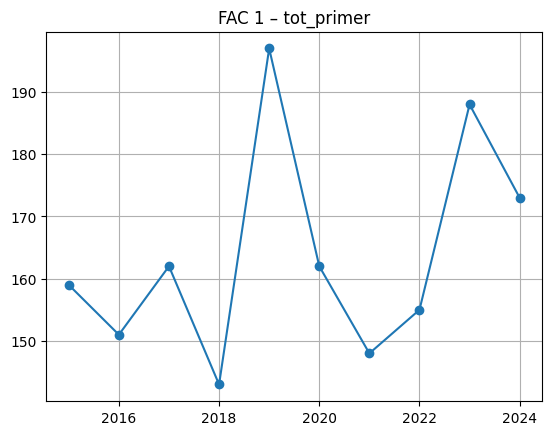

In [ ]:
import matplotlib.pyplot as plt

fac = 1  # cambia al ID que quieras
g = df_extrap[df_extrap['facultad_id'] == fac]

plt.plot(g['anio'], g['tot_primer'], marker='o')
plt.title(f'FAC {fac} – tot_primer')
plt.grid(True)
plt.show()


In [ ]:
df_extrap['prop_h_primer'] = df_extrap['h_primer'] / df_extrap['tot_primer']

df_extrap[df_extrap['anio'] == 2024][['facultad_id','prop_h_primer']]


,facultad_id,prop_h_primer
9,1,0.410405
19,2,0.390244
29,3,0.492537
39,4,0.440000
49,5,0.863946
59,6,0.684848
69,7,0.503185
79,8,0.494118
89,9,0.474684
99,10,0.628205


In [ ]:
from google.colab import files
files.download("tutorias_extrapolado.csv")



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>